# Brain Food:
## Recipe Recommender System

In [1]:
# Import relevant packages and setup display
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
import time
import re
import string
import scipy
import collections

from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.summarization import keywords
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

c:\users\corey\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data
Load in 4 recipe files from archive stored locally.

In [2]:
# Recipe directory path
path = os.path.join(os.getcwd(),'recipes')
recipes = os.listdir(path)

# Load in data
list_ = []
for recipe in recipes:
    df = pd.read_json(os.path.join(path,recipe), compression='xz', lines=True, encoding='Latin-1')
    list_.append(df)
    
# Get Column names and shape of each dataset
recipes_ = [x.split('.')[0].replace('-',' ').upper() for x in recipes]
data_cols = {}
for df,name in enumerate(recipes_):
    data_cols[name]=[list_[df].columns.tolist(),list_[df].shape]

# check columns from each dataset for merging
col_df = pd.DataFrame(data_cols)
print(col_df)

                                                                                                                                                                              ALLRECIPES RECIPES  \
0  [author, cook_time_minutes, description, error, footnotes, ingredients, instructions, photo_url, prep_time_minutes, rating_stars, review_count, time_scraped, title, total_time_minutes, url]   
1  (225602, 15)                                                                                                                                                                                    

                                                                                                                                                                                                               BBCCOUK RECIPES  \
0  [chef, chef_id, cooking_time_minutes, description, error, ingredients, instructions, instructions_detailed, photo_url, preparation_time_minutes, program, program_id, serves, time_scr

# Prepare Data
The 4 files need to be prepared such that all extra (irrelevant) columns are dropped and remaining column names match for combining.

In [3]:
################################ Allrecipes Recipes ################################
allrecipes = list_[0]

# Drop error, author, time_scraped, photo_url
# Error Column is always False, Author is user_name for website, time_scraped and photo_url aren't important

allrecipes = allrecipes.drop(['author', 'error', 'time_scraped', 'photo_url'], 1)

# change name of rating-stars to rating, and drop minutes from time variables
allrecipes.rename({'rating_stars':'rating', 
                   'cook_time_minutes':'cook_time',
                   'prep_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)

# combine the footnote column with the description column
allrecipes.footnotes = allrecipes.footnotes.apply(str)
allrecipes.description = allrecipes.description.str.cat(allrecipes.footnotes, sep=' ')
allrecipes.description = allrecipes.description.str.replace('[','').str.replace(']','')

# Drop footnote
allrecipes = allrecipes.drop('footnotes',1)


# Drop duplicates
allrecipes.ingredients = allrecipes.ingredients.apply(', '.join)
allrecipes = allrecipes.drop_duplicates(subset='ingredients',keep='first')



################################ BBC CO UK Recipes ################################
bbcrecipes = list_[1]

# Add program to descriptions
bbcrecipes.program = bbcrecipes.program.apply(str)
bbcrecipes.description = bbcrecipes.description.str.cat(bbcrecipes.program, sep=' ')

# Drop error, chef, chef_id, instructions_detailed, photo_url, program, program_id, serves, time_scraped
bbcrecipes = bbcrecipes.drop(['error', 'chef', 'chef_id', 
                              'instructions_detailed', 'photo_url', 
                              'program', 'program_id', 'serves', 'time_scraped'], 1)

bbcrecipes.rename({'cooking_time_minutes':'cook_time',
                   'preparation_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)



################################ COOKSTR Recipes ################################
cookstrecipes = list_[2]

# Append the cookbook, publisher cooking_method, cost, course, chef, contributor, dietary_considerations, 
# difficulty, meal, occasion, taste/texture, and type of dish to the description

# Change description to og_description
cookstrecipes.rename(columns={'description':'description_og'}, inplace=True)
cols_to_append = ['chef', 'contributors', 'cookbook', 'cookbook_publisher', 
                  'cooking_method', 'cost', 'course', 'dietary_considerations',
                  'difficulty', 'meal', 'occasion', 'taste_and_texture', 'type_of_dish']
cookstrecipes['description'] = cookstrecipes['description_og'].str.cat(cookstrecipes[cols_to_append].astype(str), sep=' ', na_rep=' ')

# Drop cols to append, comment_count, copyright, date_modified, error, 
# ingredients_detailed, kid_friendly, make_ahead, makes, photo stuff, and time scraped
drop_cols = cols_to_append +['description_og','rating_count', 'comment_count', 'copyright',
                                  'date_modified','error','ingredients_detailed',
                                  'kid_friendly','make_ahead','makes',
                                  'photo_credit_name','photo_credit_site','photo_url','time_scraped']
cookstrecipes = cookstrecipes.drop(drop_cols, 1)

# Fill missing ratings with 0
cookstrecipes.rating_value.fillna(0,inplace=True)

# Rename rating
cookstrecipes.rename({'rating_value':'rating'}, axis=1, inplace=True)



################################ epicurious check ################################
epicuriousrecipes = list_[3]

# Description = dek+hed+prepSteps (Instructions)
epicuriousrecipes['description'] = epicuriousrecipes.dek.str.cat([epicuriousrecipes.hed.map(str)], sep=' ')

# Rename columns
epicuriousrecipes.rename({'prepSteps':'instructions', 
                          'aggregateRating':'rating', 
                          'reviewsCount':'review_count'}, axis=1, inplace=True)

# Change rating scale to 0-5
epicuriousrecipes.rating = epicuriousrecipes.rating*(5/4)

# Drop 100 missing ingredient recipes and other columns
epicuriousrecipes = epicuriousrecipes.dropna(0)
drop_cols = ['author','dateCrawled', 'id', 'dek', 'hed', 'photoData', 'pubDate', 'type', 'willMakeAgainPct', 'tag']
epicuriousrecipes = epicuriousrecipes.drop(drop_cols,1)



################################ Make full dataframe ################################
dfs = [allrecipes, bbcrecipes, cookstrecipes, epicuriousrecipes]
df_all = pd.concat(dfs,0,sort=True,ignore_index=True)
print("Done!\nFull recipe dataset is ready!")
print("Final shape: {:,} rows with {} columns".format(df_all.shape[0], df_all.shape[1]))

# Check out missings
nulls = df_all.isnull().sum(axis=0)
counts = df_all.count(axis=0)
perc = (round((nulls/counts)*100)).astype(int)
print("\nMissings by column")
print(perc.apply(lambda x: str(x)+str('% missing')))

Done!
Full recipe dataset is ready!
Final shape: 144,247 rows with 10 columns

Missings by column
cook_time       42% missing
description     0% missing 
ingredients     0% missing 
instructions    0% missing 
prep_time       42% missing
rating          8% missing 
review_count    15% missing
title           32% missing
total_time      32% missing
url             0% missing 
dtype: object


# Clean Text
Combine the text columns: ingredients, instructions, and description to increase the number of words for the model.  Manually clean the text prior to parsing through spaCy to save time.

In [4]:
# Drop missings
recipe_df = df_all.dropna(1)

# Add title and rating back
recipe_df['title'] = df_all.title
recipe_df['rating'] = df_all.rating

# Pad columns to avoid issues when concatenating columns
for col in ['description', 'instructions']:
    recipe_df.loc[:,col] = recipe_df.loc[:,col].apply(lambda x: ' '+str(x))

# create "corpus" for each recipe
recipe_df.loc[:,'corpus'] = recipe_df['ingredients'].astype(str)+\
                            recipe_df['instructions'].astype(str)+\
                            recipe_df['description'].astype(str)

# Take a peak at the text
print(recipe_df.corpus[0])

1/2 cup unsalted butter, chilled and cubed, 1 cup chopped onion, 1 3/4 cups cornmeal, 1 1/4 cups all-purpose flour, 1/4 cup white sugar, 1 tablespoon baking powder, 1 1/2 teaspoons salt, 1/2 teaspoon baking soda, 1 1/2 cups buttermilk, 3 eggs, 1 1/2 cups shredded pepperjack cheese, 1 1/3 cups frozen corn kernels, thawed and drained, 2 ounces roasted marinated red bell peppers, drained and chopped, 1/2 cup chopped fresh basil ['Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan.', 'Melt 1 tablespoon butter in medium nonstick skillet over medium-low heat. Add onion and saute until tender, about 10 minutes. Cool.', 'Mix cornmeal with the flour, baking powder, sugar, salt, and baking soda in large bowl. Add 7 tablespoons butter and rub with fingertips until mixture resembles coarse meal.', 'Whisk buttermilk and eggs in medium bowl to blend. Add buttermilk mixture to dry ingredients and stir until blended. Mix in cheese, corn, red peppers, basil, and onion. Transf

In [5]:
# Wikipedia stopwords
wiki_stop = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as',
                     'at','be','because','been','but','by','can','cannot','could','dear','did','do',
                     'does','either','else','ever','every','for','from','get','got','had','has','have','he',
                     'her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least',
                     'let','like','likely','may','me','might','most','must','my','neither','no','nor','not','of','off',
                     'often','on','only','or','other','our','own','rather','said','say','says','she','should','since',
                     'so','some','than','that','the','their','them','then','there','these','they','this','tis','to',
                     'too','twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
                     'will','with','would','yet','you','your']
# NLTK Stop words
nltk_stop = list(stopwords.words("English"))

# Stop_words stop words
stop_words_py = get_stop_words('english')

# sklearn stop words
sk_stop = list(ENGLISH_STOP_WORDS)

# spaCy stop words
spacy_stop = list(STOP_WORDS)

all_stopwords = set(wiki_stop+nltk_stop+stop_words_py+sk_stop+spacy_stop)


############################## text cleaner ##############################
def manual_text_cleaner(txt):
    
   # Remove all digits
    txt = re.sub(r'\d',' ',txt)
    
    # Remove punctuation.
    puncs = str.maketrans("","", string.punctuation)
    txt = txt.translate(puncs)
    
    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in (all_stopwords)])
    
    # make lowercase
    txt = txt.lower()
    
    # Get rid of extra whitespace.
    txt = ' '.join(txt.split())
    
    return txt
##########################################################################################

t0=time.time()
recipe_df.loc[:,'cleaned_text_1'] = recipe_df.corpus.apply(manual_text_cleaner)
print("Time to manually clean text: {:0.5f}s".format(time.time()-t0))

# Check our manual cleaning
print('\nClean Check #1:')
print(recipe_df.cleaned_text_1[0])

Time to manually clean text: 18.65604s

Clean Check #1:
cup unsalted butter chilled cubed cup chopped onion cups cornmeal cups allpurpose flour cup white sugar tablespoon baking powder teaspoons salt teaspoon baking soda cups buttermilk eggs cups shredded pepperjack cheese cups frozen corn kernels thawed drained ounces roasted marinated red bell peppers drained chopped cup chopped fresh basil preheat oven degrees f degrees c butter x x inch baking pan melt tablespoon butter medium nonstick skillet mediumlow heat add onion saute tender minutes cool mix cornmeal flour baking powder sugar salt baking soda large bowl add tablespoons butter rub fingertips mixture resembles coarse meal whisk buttermilk eggs medium bowl blend add buttermilk mixture dry ingredients stir blended mix cheese corn red peppers basil onion transfer prepared pan bake cornbread golden tester inserted comes clean minutes cool minutes pan cut cornbread squares i started adding favorite things basic cornbread i came grea

## Remove the most common non-food words
Find the most frequent words in the data and from the top 1%, remove all of the non-food words.

In [6]:
t0=time.time()

# Make a giant string of all text
soup = recipe_df.cleaned_text_1.tolist()

# Tokenize with nltk to count words
word_soup_tokens = []
for x in range(len(soup)):
    word_soup_tokens.append(word_tokenize(soup[x]))
    
# Flatten list
word_soup = [word for sublist in word_soup_tokens for word in sublist]
print("Time to make soup: {:0.5f}s".format(time.time()-t0))

# Count most frequent words in word soup
counter = collections.Counter(word_soup)

# Get top word count
word_count = pd.Series(counter).sort_values(ascending=False)

# Cut off top 1% of words
print('\nTop words cut-off = {} words'.format(np.around(np.quantile(word_count, .99), decimals=-2)))
word_count_top = word_count[word_count>3000]

# Write out drop-list for manual tagging
word_count_top.to_csv('C:\\Users\\Corey\\Desktop\\word_count_top.csv')
drop_list = pd.read_csv('drop_list.csv', names=['food','drop'])
drop_list = drop_list[drop_list['drop']==1]['food'].tolist()

# remove most frequent non food words 
def remove_most_freq(text):
    return ' '.join([word for word in text.split() if word not in drop_list])

t0=time.time()
recipe_df.loc[:,'cleaned_text_2'] = recipe_df.loc[:,'cleaned_text_1'].apply(remove_most_freq)
print('Time to remove most frequent non-food words: {:0.5f}s'.format(time.time()-t0))
print('\nClean Check #2:')
print(recipe_df.cleaned_text_2[0])

Time to make soup: 80.71200s

Top words cut-off = 3000.0 words
Time to remove most frequent non-food words: 75.74200s

Clean Check #2:
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came


# Parse Text, Lemmatize, and Build TFIDF Vectorizer
Tokenize and lemmatize the text with spaCy. Using the lemmatized recipes, build a TFIDF matrix.

In [7]:
# Parse the dataset and tokenize - disable everything but the tokenizer
t0=time.time()
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

# Parse recipes
doc = recipe_df.cleaned_text_2.apply(nlp)
print("Time to parse text through spaCy: {:0.5f}s".format(time.time()-t0))
print("\nSpaCy tokens check:")
print(doc[0])

# Lemmatize
def get_lemmas(text):
    allwords = [token.lemma_ for token in text
                if token.is_alpha
                and not token.is_punct 
                and not token.is_stop 
                and not token.is_digit 
                and not token.like_num]
    return ' '.join(allwords)

t0=time.time()
doc_lemma = doc.apply(get_lemmas)
print("\nTime to get lemmas: {:0.5f}s".format(time.time()-t0))
print('\nSpaCy lemmas check:')
print(doc_lemma[0])

# Build TFIDF vectorizer
t0=time.time()
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                   min_df=2,
                                   stop_words='english',
                                   use_idf=True,
                                   norm='l2')#,
                                   #ngram_range=(1,2))
                                  
# Tfidf Matrix
X = tfidf_vectorizer.fit_transform(doc_lemma)
print("\nTime to create tfidf recipe matrix: {:0.5f}s".format(time.time()-t0))
print("TFIDF matrix shape: {} x {}".format(X.shape[0],X.shape[1]))

# Create tfidf vocab
vocab = tfidf_vectorizer.vocabulary_

Time to parse text through spaCy: 278.02221s

SpaCy tokens check:
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came

Time to get lemmas: 9.86404s

SpaCy lemmas check:
butter onion cornmeal flour sugar powder salt soda buttermilk egg pepperjack cheese freeze corn kernel marinate bell pepper fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertip resemble buttermilk egg buttermilk cheese corn pepper basil onion cornbread golden tester cornbread start favorite thing basic cornbread come

Time to create tfidf recipe matrix: 8.46905s
TFIDF matrix shape: 144247 x 32801


# Get Keywords
The keywords for each recipe are returned based on which 10 words per recipe have highest TFIDF score.

In [8]:
def get_keywords2(csr_matrix):
    
    # Reverse order of vocabulary matrix
    index_word={i[1]:i[0] for i in vocab.items()}
    full_match = []
    for row in csr_matrix:
        # Append the word:tfidf value as a tuple for each recipe
        full_match.append(sorted([(index_word[word_col],tfidf_val) for (word_col,tfidf_val) in zip(row.indices,row.data)],
                                 key=lambda x: -x[1])[:10])
    return full_match

# Get keywords
tfidf_keywords = get_keywords2(X)

# Add keywords to recipe_df
def extract_keywords(li):
    return [word[0] for word in li]
def extract_vectors(li):
    return np.asarray([word[1] for word in li])

recipe_df['tfidf_keywords_scores'] = tfidf_keywords
recipe_df['tfidf_keywords'] = recipe_df['tfidf_keywords_scores'].apply(extract_keywords)
recipe_df['keyword_vectors'] = recipe_df['tfidf_keywords_scores'].apply(extract_vectors)

# Fill Missing Titles
Use the top 3 keywords inplace of a missing title.

In [9]:
# Add the top 3 keywords for NaN titles
missing_title_df = recipe_df[recipe_df['title'].isnull()]
indices = recipe_df[recipe_df['title'].isnull()].index

# Get top 3 keywords
new_titles = []
for row in missing_title_df.tfidf_keywords:
    new_titles.append('Top 3 Keywords: '+str(', '.join(row[:3])))

# Zip indices to new titles
new_title_dict = dict(zip(indices,new_titles))

# Fill NaN with new titles
recipe_df.title = recipe_df.title.fillna(new_title_dict)

# Brain Food Function
Function takes input string, cleans it, and creates an N-d vector (N = length of TFIDF vocabulary), where each cleaned word is tagged with 1 when matched in the vocabulary, else 0.  The input vector is multiplied against the TFIDF matrix, results are sorted in descending order and top 10 are returned.

In [10]:
def brain_food_1(input_list):
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # One hot encode input vector
    lemmas = lemmas.split()
    for word in lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords', 'url']].head(10)


# Run Function
brain_food_1('potatoes cheese bacon eggs')

,title,cleaned_text_2,tfidf_keywords,url
13109,Cheesy Fried Potatoes,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
16026,Potato Skillet,bacon potatoes garlic salt salt pepper eggs cheddar cheese bacon large bacon crumble bacon potatoes bacon garlic salt seasoned salt pepper potatoes potatoes tender bacon eggs potatoes cheese son loves doesnt care breakfast,"[bacon, potato, son, salt, care, love, crumble, cheese, breakfast, egg]",http://allrecipes.com/Recipe/24156/
11560,Cheese and Bacon Potato Rounds,potatoes butter bacon cheddar cheese onions potato butter cookie potatoes bacon cheese onion cheese potatoes cheese bacona sour cream desire,"[potato, cheese, bacon, desire, onion, butter, cookie, cheddar, sour, cream]",http://allrecipes.com/Recipe/18344/
19739,Bacon Sunshine Skillet,oil frozen hash potatoes eggs oscar mayer bacon onions salt pepper kraft cheddar cheese tomatoes oil potatoes potatoes potatoes eggs bacon onions salt pepper egg potatoes eggs cheese tomatoes onions bacon sunshine,"[potato, bacon, egg, sunshine, mayer, oscar, hash, onion, tomato, kraft]",http://allrecipes.com/Recipe/37750/
25179,Potato Rounds,large potatoes bacon cheddar cheese potatoes large water tender pierced bacon large crisp crumble potatoes crumbles bacon cheddar cheese cheese potato bacon cheese appetizer lot potato skins,"[potato, bacon, crumble, cheese, cheddar, pierce, skin, lot, appetizer, large]",http://allrecipes.com/Recipe/70699/
41442,Bacon Potato Omelet,bacon potatoes onion eggs salt pepper cheddar cheese bacon crisp drippings bacon potatoes onion drippings tender eggs salt pepper eggs salt pepper eggs cheese cheese bacon loosen fun present basic breakfast potatoes eggs bacon family favorite inherited motherinlaw,"[bacon, egg, drippings, potato, inherit, cheese, motherinlaw, present, basic, pepper]",http://allrecipes.com/Recipe/121545/
24962,Breakfast Upside Down Cake,olive oil large potatoes bell pepper cloves garlic onion salt pepper bacon eggs milk cheddar cheese olive oil large potatoes bell pepper garlic onion potatoes tender faster cake bacon crisp crumble cheese bacon crumbles cheese potato distributed eggs milk salt pepper egg outer flip things good breakfast potatoes bacon cheese eggs easy presents beautifully excellent company,"[potato, bacon, crumble, cheese, egg, bell, pepper, present, beautifully, company]",http://allrecipes.com/Recipe/69516/
32714,Campfire Skillet Breakfast,bacon potatoes onion optional eggs cheddar cheese bacon doneness cast iron burning coals campfire bacon potatoes onion bacon potatoes crumble bacon potatoes eggs cheese camping easy,"[bacon, potato, campfire, camp, cast, coal, iron, doneness, burn, crumble]",http://allrecipes.com/Recipe/105678/
85235,Laura's Breadless Fried Egg Sandwich,bacon eggs salt pepper cheddar cheese bacon large crumble crack eggs salt pepper egg whites flip eggs bacon cheddar cheese egg doneness cheese egg crispy bacon cheddar cheese stuffed fried eggs so delicious,"[bacon, egg, cheddar, cheese, doneness, flip, crack, crispy, crumble, fry]",http://allrecipes.com/Recipe/245539/


# Word2Vec
Build a word2vec model to use the vocabulary and word vectors to determine words similar to the input list.  Add the similar words to the input vector to increase the diversity of recipes returned.

In [11]:
#Build list of lists for word2vec from cleaned and lemmatized corpus
lemma_list = [x.split() for x in doc_lemma]

# Instantiate word2vec model
t0=time.time()
print('Builing vocabulary...')
w2v = word2vec.Word2Vec(lemma_list,        # build vocabulary on entire corpus - must be list of lists
                        workers=8,         # Number of threads in parallel
                        min_count=10,      # Minimum word count threshold.
                        window=12,         # Number of words around target word to consider.
                        sg=0,              # Use CBOW because our corpus is small.
                        sample=1e-5,       # Penalize frequent words.
                        size=200,          # Word vector length.
                        hs=1,              # Use hierarchical softmax.
                        iter=10)           # Epoch=10
print('Done!')
print("Time to build word vectors: {:.5f}s".format(time.time()-t0))

Builing vocabulary...
Done!
Time to build word vectors: 31.67096s


In [12]:
# Test Word2Vec
test_list = ['cornbread', 'onion', 'corn', 'cheese', 'buttermilk', 'pepper']
for test in test_list:
    print(test)
    print(w2v.wv.most_similar(test,topn=5))
    print('-----'*20)

cornbread
[('cornmeal', 0.49178430438041687), ('creamstyle', 0.4515250623226166), ('jiffy', 0.422915518283844), ('review', 0.4182749390602112), ('dragonwagon', 0.40711426734924316)]
----------------------------------------------------------------------------------------------------
onion
[('pepper', 0.7294040322303772), ('garlic', 0.6687633991241455), ('clove', 0.6057111024856567), ('celery', 0.5984206199645996), ('tender', 0.5776463747024536)]
----------------------------------------------------------------------------------------------------
corn
[('kernel', 0.8145608305931091), ('cob', 0.7167619466781616), ('ear', 0.6855152249336243), ('creamstyle', 0.612373948097229), ('cornonthecob', 0.5672372579574585)]
----------------------------------------------------------------------------------------------------
cheese
[('cheddar', 0.6601715087890625), ('parmesan', 0.6344162225723267), ('mozzarella', 0.6274643540382385), ('bubbly', 0.5576629638671875), ('spinachartichoke', 0.52472966909408

In [13]:
def brain_food_2(input_list):
    '''Adds additional most similar words from word2vec model'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

# Run Function
brain_food_2('potatoes cheese bacon eggs')

Your keyword ingredients are:
 ['potato', 'cheese', 'bacon', 'egg', 'russet', 'cheddar', 'thickcut', 'yolk']


,title,cleaned_text_2,tfidf_keywords,url
73810,Easy Loaded Baked Potato Casserole,yukon gold potatoes bacon cheddar cheese milk sour cream salt pepper onions cheddar cheese potatoes large water tender potatoes bacon large bacon crumble cheddar cheese milk sour cream salt pepper potatoes potato masher creamy potato bacon onions cheddar cheese cheese easy potato casserole bacon cheddar onions,"[potato, bacon, cheddar, cheese, sour, onion, yukon, masher, gold, milk]",http://allrecipes.com/Recipe/231699/
13109,Cheesy Fried Potatoes,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
85235,Laura's Breadless Fried Egg Sandwich,bacon eggs salt pepper cheddar cheese bacon large crumble crack eggs salt pepper egg whites flip eggs bacon cheddar cheese egg doneness cheese egg crispy bacon cheddar cheese stuffed fried eggs so delicious,"[bacon, egg, cheddar, cheese, doneness, flip, crack, crispy, crumble, fry]",http://allrecipes.com/Recipe/245539/
26543,Teena's Bacon and Cheddar Potatoes,large russet potatoes scrubbed butter bacon onion cottage cheese onion cheddar cheese salt pepper butter cheddar cheese paprika potatoes large water tender potatoes butter bacon large bacon drippings bacon towellined crumble bacon onion onion turned scrape onion potatoes bacon cottage cheese onion cheddar cheese salt pepper potato dot butter cheddar cheese paprika cheese bubbling yummy potato goes chicken beef usual suspects thanksgiving,"[bacon, potato, cheese, cheddar, onion, cottage, suspect, paprika, butter, usual]",http://allrecipes.com/Recipe/76462/
25179,Potato Rounds,large potatoes bacon cheddar cheese potatoes large water tender pierced bacon large crisp crumble potatoes crumbles bacon cheddar cheese cheese potato bacon cheese appetizer lot potato skins,"[potato, bacon, crumble, cheese, cheddar, pierce, skin, lot, appetizer, large]",http://allrecipes.com/Recipe/70699/
88823,Twice-Baked Potato Casserole,butter russet potatoes salt sour cream cream cheese cheddar cheese real bacon chives optional butter potatoes large water tender potatoes salt sour cream cream cheese cheddar cheese bacon potato cheddar cheese cheese chives easy delicious always favorite busy things buy readytomash potatoes frozen section potatoes,"[potato, cheese, cheddar, cream, chive, bacon, sour, busy, russet, buy]",http://allrecipes.com/Recipe/256027/
24899,Bacon Cheddar Deviled Eggs,eggs mayonnaise bacon cheddar cheese mustard eggs water water eggs water water eggs running water bacon large alternatively bacon crumble hardcooked eggs yolks egg yolks mayonnaise bacon cheese mustard egg yolk deviled eggs include bacon cheddar cheese ordinary deviled eggs,"[bacon, egg, devil, yolk, water, mayonnaise, cheddar, mustard, cheese, ordinary]",http://allrecipes.com/Recipe/69084/
136753,"Top 3 Keywords: bacon, potato, onion",bacon onion large eggs russet potatoes cheddar pepper bacon onion large bacon crisp onion eggs bacon spreading bacon potato pie,"[bacon, potato, onion, russet, spread, egg, cheddar, pie, crisp, large]",/recipes/food/views/bacon-and-potato-pie-1590
71663,Spicy Bacon Deviled Eggs,eggs bacon mayonnaise cheddar cheese spicy mustard wasabi eggs water eggs water eggs water running water eggs yolks hollow egg whites bacon large bacon crumble bacon cheddar cheese remainder egg yolks mayonnaise mustard wasabi egg whites heaping spoonful yolk bacon ched

# Accuracy Metric
The accuracy of the recommender will be measured by the average similarity of input words matched to the keywords generated for each recipe.  If the input word is NOT in the keywords of the recipe, the most similar word from the keywords is returned and the similarity score for that word is added to the vector.  Words that match in the keywords have similarity scores equal to 1.  The vector is averaged and higher the average the better the accuracy.  Recipes with a perfect score reflect a recipe(s) where 100% of the input words are found as keywords for that recipe.

In [14]:
def recommender_metric(input_list, series):
    '''Calculates a score for each recipe in terms of matching input to tfidf keywords'''
    score = []
    # For each word in the input list
    for word in input_list:
        # Check if it is in the tfidf keywords
        if word not in series:
            max_holder=[]
            # Return max similarity for word from input list to tfidf keywords
            for kw in series:
                try:
                    max_holder.append(w2v.wv.similarity(word,kw))
                except:
                    score.append(0)
            try:
                score.append(max(max_holder))
            except:
                pass
        else:
            score.append(1)
            
    return sum(score)/len(score)

# Final Brain Food Build
Instead of equally weighting the similar word matches in the input vector, use the cosine similarity score to add weights to similar word.  Add the metric to rank order the results by score.

In [99]:
def brain_food_4(input_list):
    ''' Adds additional similar word cosine similarity score to input vector
        Built on full tfidf matrix
        Adds in metric'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    similar_words = []
    for word in lemmas:
        try:
            similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0])
            similar_words.append(w2v.wv.most_similar(word,topn=1)[0][0])
        except:
            pass
    
    diverse_lemmas = lemmas+similar_words
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in lemmas:
        try:
            input_vec[vocab[word]] += 1
        except:
            pass
        
    # Add cosine similarities for similar word score
    for word,score in similar_to_input:
        try:
            input_vec[vocab[word]] += score
        except:
            pass
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
        
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    top_recipes = recipe_df_alias[:10]
    
    # Calculate metrics
    top_recipes['match_score'] = top_recipes.tfidf_keywords.apply(lambda scr: recommender_metric(lemmas,scr))
    
    return top_recipes[['title','match_score', 'cleaned_text_2', 'tfidf_keywords','url']].sort_values(by='match_score',ascending=False)

# Run Function
brain_food_4('potato cheese bacon eggs')

Your keyword ingredients are:
 ['potato', 'cheese', 'bacon', 'egg', 'russet', 'cheddar', 'thickcut', 'yolk']


,title,match_score,cleaned_text_2,tfidf_keywords,url
13109,Cheesy Fried Potatoes,1.000000,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,1.000000,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
16026,Potato Skillet,1.000000,bacon potatoes garlic salt salt pepper eggs cheddar cheese bacon large bacon crumble bacon potatoes bacon garlic salt seasoned salt pepper potatoes potatoes tender bacon eggs potatoes cheese son loves doesnt care breakfast,"[bacon, potato, son, salt, care, love, crumble, cheese, breakfast, egg]",http://allrecipes.com/Recipe/24156/
136753,"Top 3 Keywords: bacon, potato, onion",0.915043,bacon onion large eggs russet potatoes cheddar pepper bacon onion large bacon crisp onion eggs bacon spreading bacon potato pie,"[bacon, potato, onion, russet, spread, egg, cheddar, pie, crisp, large]",/recipes/food/views/bacon-and-potato-pie-1590
73810,Easy Loaded Baked Potato Casserole,0.881754,yukon gold potatoes bacon cheddar cheese milk sour cream salt pepper onions cheddar cheese potatoes large water tender potatoes bacon large bacon crumble cheddar cheese milk sour cream salt pepper potatoes potato masher creamy potato bacon onions cheddar cheese cheese easy potato casserole bacon cheddar onions,"[potato, bacon, cheddar, cheese, sour, onion, yukon, masher, gold, milk]",http://allrecipes.com/Recipe/231699/
11560,Cheese and Bacon Potato Rounds,0.878790,potatoes butter bacon cheddar cheese onions potato butter cookie potatoes bacon cheese onion cheese potatoes cheese bacona sour cream desire,"[potato, cheese, bacon, desire, onion, butter, cookie, cheddar, sour, cream]",http://allrecipes.com/Recipe/18344/
26543,Teena's Bacon and Cheddar Potatoes,0.878790,large russet potatoes scrubbed butter bacon onion cottage cheese onion cheddar cheese salt pepper butter cheddar cheese paprika potatoes large water tender potatoes butter bacon large bacon drippings bacon towellined crumble bacon onion onion turned scrape onion potatoes bacon cottage cheese onion cheddar cheese salt pepper potato dot butter cheddar cheese paprika cheese bubbling yummy potato goes chicken beef usual suspects thanksgiving,"[bacon, potato, cheese, cheddar, onion, cottage, suspect, paprika, butter, usual]",http://allrecipes.com/Recipe/76462/
25179,Potato Rounds,0.868781,large potatoes bacon cheddar cheese potatoes large water tender pierced bacon large crisp crumble potatoes crumbles bacon cheddar cheese cheese potato bacon cheese appetizer lot potato skins,"[potato, bacon, crumble, cheese, cheddar, pierce, skin, lot, appetizer, large]",http://allrecipes.com/Recipe/70699/
88823,Twice-Baked Potato Casserole,0.851496,butter russet potatoes salt sour cream cream cheese cheddar cheese real bacon chives optional butter potatoes large water tender potatoes salt sour cream cream cheese cheddar cheese bacon potato cheddar cheese cheese chives easy delicious always favorite busy things buy readytomash potatoes frozen section potatoes,"[potato, cheese, cheddar, cream, chive, bacon, sour, busy, russet, buy]",http://allrecipes.com/Recipe/256027/
85235,Laura's Breadless Fried Egg Sandwich,0.823175,bacon eggs salt pepper cheddar cheese bacon large crumble crack eggs salt pepper egg whites flip eggs bacon cheddar cheese egg doneness cheese egg crispy bacon cheddar cheese stuffed fried eggs so delicious,"[bacon, egg, cheddar, cheese, doneness, flip, crack, crispy, crumble, fry]",http://allrecipe

# Test
Test the system using a random sample of 1000 different ingredient lists as input for the function.  Each ingredient list that returns itself is successful.
* Added options to test using cleaned_text_2 and tfidf keywords for each recipe instead of 10 ingredients.  Same scoring applies.

In [96]:
def test_system(n,test1):
    
    # Time the test
    t0=time.time()
    if test1==0:
        # Get random sample of n different recipe ingredients
        test = recipe_df.ingredients.sample(n)

        # Clean, tokenize, and lemmatize ingredients
        clean_test = test.apply(lambda x: manual_text_cleaner(str(x))).apply(remove_most_freq).apply(nlp).apply(get_lemmas)

        # Make string from k ingredients
        clean_test_chunks = clean_test.apply(lambda x: ' '.join(x.split()[:10]))
        
        label = 'ingredients'
    
    elif test1==1:
        # Use cleaned_text_2 text
        clean_test_chunks = recipe_df.cleaned_text_2.sample(n)
        clean_test_chunks = clean_test_chunks.apply(lambda x: ' '.join(x.split()[:10]))
        
        label = 'cleaned_text_2'
    
    else:
        # Use tfidf_keywords
        clean_test_chunks = recipe_df.tfidf_keywords.sample(n)
        clean_test_chunks = clean_test_chunks.apply(lambda x: ' '.join(x))
    
        label = 'tfidf_keywords'
    
    # Get list of indices for sample ingredients
    sample_indices = clean_test_chunks.index
    
    # Test each string of ingredients to see if it's recipe is returned
    hold_df = []
    counter = 0
    for recipe in clean_test_chunks:
        hold_df.append(brain_food_4(recipe))
        counter+=1
        # check to see where were at
        if counter%100==0:
            print("Testing recipe ",counter)
        
    # Get list of indices for matched recipes
    match = 0
    for sample,df in zip(sample_indices,hold_df):
        if sample in df.index:
            match+=1
                
    print("Time to test {} recipes using ".format(n)+label+": {:0.5f}s".format(time.time()-t0))
    print('Accuracy: {:0.2f}%'.format((match/n)*100))
    return

In [98]:
test_system(1000, test1=False)
print('-'*50)
test_system(1000, test1=True)
print('-'*50)
test_system(1000, test1=3)

Testing recipe  100
Testing recipe  200
Testing recipe  300
Testing recipe  400
Testing recipe  500
Testing recipe  600
Testing recipe  700
Testing recipe  800
Testing recipe  900
Testing recipe  1000
Time to test 1000 recipes using ingredients: 1438.58229s
Accuracy: 49.40%
--------------------------------------------------
Testing recipe  100
Testing recipe  200
Testing recipe  300
Testing recipe  400
Testing recipe  500
Testing recipe  600
Testing recipe  700
Testing recipe  800
Testing recipe  900
Testing recipe  1000
Time to test 1000 recipes using cleaned_text_2: 1457.73655s
Accuracy: 52.10%
--------------------------------------------------
Testing recipe  100
Testing recipe  200
Testing recipe  300
Testing recipe  400
Testing recipe  500
Testing recipe  600
Testing recipe  700
Testing recipe  800
Testing recipe  900
Testing recipe  1000
Time to test 1000 recipes using tfidf_keywords: 1406.91761s
Accuracy: 100.00%


# Conclusion
Brain Food is a recipe recommender system that is built on an aggregation of recipes scraped from four web sources.  Recipes along with other metadata were scraped from the websites: allrecipes.com, bbc.com/food/recipes, epicurious.com, and cookstr.com. Data was collected in to online archive, https://archive.org/download/recipes-en-201706/.  This archive was downloaded and served as the raw data for the recommender.

The driving force behind the creation of Brain Food is convenience, first and foremost.  The goal is to create a product that would save time and headache at the end of the day.  Brain food is designed to take in a string of ingredients and return a set of recipes that closely match the input string.  A metric was created to measure how well these results matched the input.  The “brain” inside Brain Food is a matrix of vectors built from the term frequency - inverse document frequency (TFIDF) for words in the recipes.  In addition to a TFIDF matrix, a word2vec model was also trained on the recipes to generate a vocabulary used for adding the most similar word to the input words.  This addition of the word2vec model increased the diversity of results.

A final test was constructed to test the overall performance of the system.  The final test took 1000 randomly sampled recipes, selected the ~~first 10 ingredients~~ TFIDF keywords, fed the selected ~~ingredients~~ keywords into Brain Food, and recorded whether or not the original recipe was returned.  If the selected items returned the original recipe the system was successful.  Brain Food performed with an accuracy of ~~around 50%~~ 100% (when tested with the tfidf keywords as inputs).  The tfidf keywords returning perfect results is expected because the tfidf keywords were selected as the words in each recipe that have the highest value and the results are generated by returning the recipes that score the highest when summing tfidf scores for words that matched in the tfidf vocabulary.  Thus, summing all of the most important words from the vocabulary should yield perfect results.

There are many ways in which this system can be improved.  To start, more rigorous text cleaning could be used.  There are a few special characters that made it through the cleaning process that can still be removed.  Clustering techniques like Latent Semantic Analysis (LSA)/ probabilistic Latent Semantic Analysis (pLSA), Non-Negative Matrix Factorization (NNMF), or Latent Dirichlet Allocation (LDA), among others, could also provide some interesting information.  Being able to filter results by a specific “topic” (e.g. Breakfast/Lunch/Dinner) or style of food (e.g. "italian", "mexican") would be nice.  Adding a dithering algorithm to the results could also offer some value by further diversifying the results.

There was an attempt to add some additional filtering of the results based on ratings, but some issues arose with this.  The thought process was to use the 100K non-missing rated recipes to build a model that predicted ratings for recipes and use the model to impute the remaining missing ratings.  At first a model was constructed using a target variable that contained five classes, 1-5 for each rating.  The classes were not evenly represented at all, with 4s and 5s dominating the classes.  With this dominating class, predicting the low ratings was increasing difficult and the results showed.  Two more attempts were made at predicting ratings, one with 3 classes, ‘would not recommend’ ‘would recommend’ and ‘highly recommend’, and one with 2 classes, ‘would not recommend’ and ‘would recommend’.  None of the models performed well enough for the imputed ratings to be valuable.

Since this is a recommender system, there are many other techniques that can be used to build the recommendations, as well as ways to improve the results.  Collaborative filtering techniques would be something to consider including, especially if the ratings were to be included in the future.

At this time in production, the system is stable and will be able to produce relevant results countless times as long as the user has access to the locally stored data.  Moving forward, Brain Food would need a website that would allow users to interact with the recommender from anywhere.  Once the website is established and people are enjoying Brain Food across the world, Brain Food would also include functionality to allow a user to upload recipes into the database, thus feeding the *Brain*.


# Appendix

## Predict Recipe Rating for secondary filtering
### Integer Rating


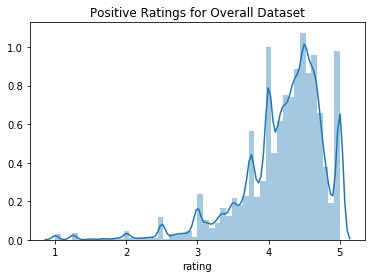

There are 104,253 non-zero ratings in the dataset


In [18]:
# 0 are missing ratings - plot only positive
sns.distplot(recipe_df.rating[recipe_df.rating>0].dropna())
plt.title('Positive Ratings for Overall Dataset')
plt.show()

print("There are {:,d} non-zero ratings in the dataset".format(recipe_df.rating[recipe_df.rating>0].notnull().sum()))

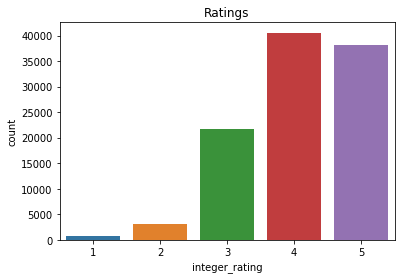

In [19]:
# create 5 categories for ratings

recipe_df['integer_rating'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(df_all.rating > 0)&(recipe_df.rating < 2),'integer_rating'] = 1
recipe_df.loc[(df_all.rating >= 2)&(recipe_df.rating < 3),'integer_rating'] = 2
recipe_df.loc[(df_all.rating >= 3)&(recipe_df.rating < 4),'integer_rating'] = 3
recipe_df.loc[(df_all.rating >= 4)&(recipe_df.rating < 4.5),'integer_rating'] = 4
recipe_df.loc[(df_all.rating >= 4.5),'integer_rating'] = 5

sns.countplot(recipe_df.integer_rating[recipe_df.integer_rating>0])
plt.title('Ratings')
plt.show()

# 3 Classes
There are not enough lower ratings for 5 classes, therefore reclassify the ratings into 3 classes. 1-3='would not recommend', 4='would recommend', and 5='highly recommend'.

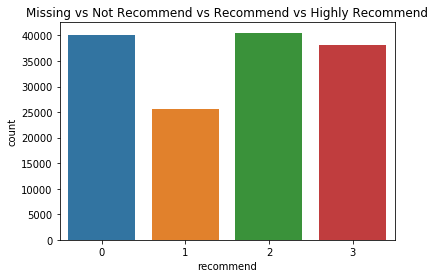

In [20]:
# 3 Classes for ratings
# 1 = 'would not recommend'
# 2 = 'would recommend'
# 3 = 'highly recommend'

recipe_df['recommend'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(recipe_df.integer_rating>0)&(recipe_df.integer_rating<=3),'recommend'] = 1
recipe_df.loc[(recipe_df.integer_rating==4),'recommend'] = 2
recipe_df.loc[(recipe_df.integer_rating==5),'recommend'] = 3

# A rating of 0 is a missing
sns.countplot(recipe_df.recommend)
plt.title("Missing vs Not Recommend vs Recommend vs Highly Recommend")
plt.show()

# Train on 80% of rated recipes - use tfidf vectors for features
rated_index = recipe_df[recipe_df.recommend>0].index
y = recipe_df.recommend.iloc[rated_index]
tfidf_features = X[X.indices[rated_index]]

# Split training and test
xtrain, xtest, ytrain, ytest = train_test_split(tfidf_features, y, test_size=0.2, random_state=34)

## Classifiers

In [21]:
def rate(model, label):
    clf = model
    clf.fit(xtrain, ytrain)
    
    # Predict on test
    clf_pred = clf.predict(xtest)
    
    # Score test
    print(label)
    print("Accuracy:",clf.score(xtest,ytest))
    print(confusion_matrix(ytest,clf_pred))
    print(classification_report(ytest, clf_pred))
    print('_'*75)
    return

In [22]:
# Naive Bayes
rate(MultinomialNB(), 'Multinomial')
rate(ComplementNB(), 'Complement')

Multinomial
Accuracy: 0.39168385209342477
[[  52 3871 1189]
 [  55 6069 1911]
 [  39 5619 2046]]
              precision    recall  f1-score   support

           1       0.36      0.01      0.02      5112
           2       0.39      0.76      0.51      8035
           3       0.40      0.27      0.32      7704

   micro avg       0.39      0.39      0.39     20851
   macro avg       0.38      0.34      0.28     20851
weighted avg       0.38      0.39      0.32     20851

___________________________________________________________________________
Complement
Accuracy: 0.3771042156251499
[[ 682 2621 1809]
 [ 917 4194 2924]
 [ 783 3934 2987]]
              precision    recall  f1-score   support

           1       0.29      0.13      0.18      5112
           2       0.39      0.52      0.45      8035
           3       0.39      0.39      0.39      7704

   micro avg       0.38      0.38      0.38     20851
   macro avg       0.35      0.35      0.34     20851
weighted avg       0.36  

In [23]:
# KNN
rate(KNeighborsClassifier(),'KNN')

KNN
Accuracy: 0.3366265406934919
[[1693 1925 1494]
 [2582 3046 2407]
 [2463 2961 2280]]
              precision    recall  f1-score   support

           1       0.25      0.33      0.29      5112
           2       0.38      0.38      0.38      8035
           3       0.37      0.30      0.33      7704

   micro avg       0.34      0.34      0.34     20851
   macro avg       0.33      0.34      0.33     20851
weighted avg       0.35      0.34      0.34     20851

___________________________________________________________________________


In [24]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=5,
                             random_state=34)
rate(rfc, "RFC")

RFC
Accuracy: 0.38741547168001533
[[   0 5020   92]
 [   0 7900  135]
 [   0 7526  178]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5112
           2       0.39      0.98      0.55      8035
           3       0.44      0.02      0.04      7704

   micro avg       0.39      0.39      0.39     20851
   macro avg       0.28      0.34      0.20     20851
weighted avg       0.31      0.39      0.23     20851

___________________________________________________________________________


## 2 Classes

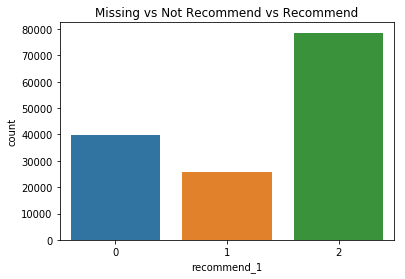

Multinomial
Accuracy: 0.7546400652246895
[[    0  5112]
 [    4 15735]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5112
           2       0.75      1.00      0.86     15739

   micro avg       0.75      0.75      0.75     20851
   macro avg       0.38      0.50      0.43     20851
weighted avg       0.57      0.75      0.65     20851

___________________________________________________________________________
Complement
Accuracy: 0.7443767685003118
[[  133  4979]
 [  351 15388]]
              precision    recall  f1-score   support

           1       0.27      0.03      0.05      5112
           2       0.76      0.98      0.85     15739

   micro avg       0.74      0.74      0.74     20851
   macro avg       0.52      0.50      0.45     20851
weighted avg       0.64      0.74      0.66     20851

___________________________________________________________________________


In [25]:
# 2 Classes for ratings
# 1 = 'would not recommend'
# 2 = 'would recommend'

recipe_df['recommend_1'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(recipe_df.integer_rating>0)&(recipe_df.integer_rating<=3),'recommend_1'] = 1
recipe_df.loc[(recipe_df.integer_rating>=4),'recommend_1'] = 2

# A rating of 0 is a missing
sns.countplot(recipe_df.recommend_1)
plt.title("Missing vs Not Recommend vs Recommend")
plt.show()

# Train on 80% of rated recipes - use tfidf vectors for features
rated_index = recipe_df[recipe_df.recommend_1>0].index
y = recipe_df.recommend_1.iloc[rated_index]
tfidf_features = X[X.indices[rated_index]]

# Split training and test
xtrain, xtest, ytrain, ytest = train_test_split(tfidf_features, y, test_size=0.2, random_state=34)

# Naive Bayes
rate(MultinomialNB(), 'Multinomial')
rate(ComplementNB(), 'Complement')

The models do not perform well enough to be added to the model.

## Old keywords finder
These functions were too slow/poorly written

In [26]:
def top_n_idx_sparse(csr_matrix, n=10):
    '''Return index of top n values in each row of a sparse matrix'''
    
    top_n_idx = []
    
    # Get the indices and tfidf values for each recipe from the csr matrix  
    for left, right in zip(csr_matrix.indptr[:-1], csr_matrix.indptr[1:]):
        
        # Makes sure vector has enough non-zero elemets
        n_row_pick = min(n,right-left)
        
        # Append top n indices
        top_n_idx.append(csr_matrix.indices[left+np.argpartition(csr_matrix.data[left:right],-n_row_pick)[-n_row_pick:]])
    return top_n_idx

def get_keywords(index_list):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = vocab.items()
    
    for item in dict_items:
        if item[1] in index_list:
            matching_keys.append(item[0])
            
    # Zip tfidf values to words
    return matching_keys

######### Allows for faster results because can now handle flattened list #############
def get_keywords1(dictionary, index_list, n=10):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = dictionary.items()
    
    # loop through flat list of indices - faster that get_keywords because allows a flatlist to be searched 
    # instead of requiring a loop through each list of indices
    counter=0
    for x in index_list:
        for item in dict_items:
            if x == item[1]:
                matching_keys.append(item[0])
                counter+=1
                if counter%100==0:
                    print('running...{}'.format(counter))
                
                
    # Split the results into the n number of keywords
    i=0
    row=0
    new_list=[]
    while i<len(matching_keys):
        new_list.append(matching_keys[i:i+n])
        i+=n
        row+=1
        if row%5000 ==0:
            print("Running row {}".format(row))
    return new_list


# Get indices for the keywords
#t0=time.time()
#keyword_indices = top_n_idx_sparse(X)

# Get list of keywords lists to add to recipe_df
#list_of_keywords = [l for subl in keyword_indices for l in subl]
    
# Add to recipe_df
#keyword_list = get_keywords1(vocab,list_of_keywords)

#print("Time to get keywords: {:0.5f}s".format(time.time()-t0))
#print(recipe_df.head())

# First Brain Food Attemt
First attempt at recommender.  This did not take into consideration the word's relationship in the vector. It simply used the values from the top 10 keywords vector to calculate the similarity with the input words, where the input words were matched with their idf score from the vocabulary built for the tfidf matrix.

In [27]:
def brain_food(input_list):
    """Function that takes up to 10 ingredients and 
    returns recipes with keywords that are the most similar to the input"""
    t0=time.time()
    # Get idf score for each word entered.  If word is not in corpus throw error.
    idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(),tfidf_vectorizer.idf_))
    
    input_vect = []
    for word in input_list:
        if word in idf_dict:
            input_vect.append(idf_dict[word])
            
        else:
            input_vect.append(0)
            print('{} not in corpus - no idf available'.format(word))
            
    # Make sure array has same number of elements as keywords
    num_keywords = len(recipe_df.keyword_vectors[0])
    ingredients = np.pad(input_vect, (0,(num_keywords-len(input_vect))), 'constant', constant_values=(0))
    
    # Get cosine similarity between input and rows
    sims = {}
    chunk = 1000
    chunk_df = recipe_df.sample(chunk)
    vectors = chunk_df.keyword_vectors.values
    index = chunk_df.index
    t = list(zip(index,vectors))
    counter = 0
    for label,array in t:
        if counter % 1000 == 0:
            print("running row", counter)
        padded_array = np.pad(array, (0,(num_keywords-len(array))), 'constant', constant_values=(0))
        sims[label] = cosine_similarity(ingredients.reshape(1, -1),padded_array.reshape(1, -1))[0]
        sims_df = pd.Series(sims).sort_values(ascending=False)
        counter+=1
        
    # Match index to recipe_df
    top=10
    top_ten = sims_df.index[:top]
    top_recipes = []
    for recipe in top_ten:
        top_recipes.append(recipe_df.loc[recipe,['title','description', 'ingredients', 'instructions', 
                                                 'url', 'integer_rating', 'tfidf_keywords_scores']])
    print("Done! Time for top {} recipes searched from {}:\n{:0.5f}s".format(top, chunk,(time.time()-t0)))
    return sims_df[:10], top_recipes
  
#brain_food(['bacon', 'eggs', 'cheese', 'bread', 'sausage', 'coffee'])

## Gensim Keywords
The gensim_set was having issues.  Also the documentation for the gensim.keywords was vague.

In [28]:
# Gensim Keywords

#print(keywords(recipe_df.cleaned_text_2[0]).split('\n'))
#t0=time.time()
#recipe_df['gensim_keyword'] = recipe_df.cleaned_text_2.apply(keywords).apply(lambda x: x.split('\n'))
#print("Time for gensim keywords: {0:.5f}s".format(time.time()-t0))

#gensim_set = set([word for sublist in recipe_df.gensim_keyword.tolist() for word in sublist])
#print(gensim_set[:100])

#t0=time.time()
#count_vec = CountVectorizer(strip_accents='unicode',
                                   #min_df=2,                # keep words that occur more than 2 times
                                   #stop_words='english',    # English stop words
                                   ##vocabulary=gensim_set,   # Build on gensim keywords from each recipe
                                   #binary=True)             # use binary flag to indicate whether or not word is present
                            
#gensim_matrix = count_vec.fit_transform(doc_lemma)
#print("Time to build tfidf keyword matrix: {:0.5f}s".format(time.time()-t0))
#print(gensim_matrix.shape)

#gensim_vocab = count_vec.vocabulary_

# Build matrix on tfidf keywords
Another attempt at building the product.  The results were not as diverse as the full TFIDF matrix (as you might expect); therefore, it was not used.

In [29]:
# Get set of unique words from tfidf keywords
keyword_set = set([word for sublist in recipe_df.tfidf_keywords.tolist() for word in sublist])

# Revectorize the recipes using only the tfidf keywords vocabulary
# use a binary flag to increase the diversity of recipes returned
count_vec = CountVectorizer(strip_accents='unicode',
                            min_df=2,                # keep words that occur more than 2 times
                            stop_words='english',    # English stop words
                            vocabulary=keyword_set,  # Build on keywords from each recipe
                            binary=True)             # use binary flag to indicate whether or not word is present
                            
tfidf_keyword_matrix = count_vec.fit_transform(doc_lemma)

# Tfidf vocabulary
tfidf_keyword_vocab = count_vec.vocabulary_

####################################################################################

def brain_food_3(input_list):
    ''' Adds additional similar words
        Keyword matrix built on tfidf keywords'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(tfidf_keyword_matrix.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[tfidf_keyword_vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_keyword_sparse = scipy.sparse.csc_matrix(tfidf_keyword_matrix)
    similarity = tfidf_keyword_sparse * input_vec
    
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

# Run Function
#brain_food_3('potatoes cheese bacon eggs')